In [121]:
# EEG Classification BCI Task
# Computational Intelligence Course Final Project
# Armin Panjehpour - 98101288

In [122]:
# Accessing google drive

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/CI_Project_Dataset/'  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [123]:
pip install nolds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [124]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from scipy.io import loadmat
from scipy.fft import fft
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from scipy import signal
from sklearn.model_selection import KFold
import scipy 
import random
import nolds

In [125]:
# Load Dataset
Data = mat = loadmat('/content/gdrive/MyDrive/Colab Notebooks/CI_Project_Dataset/CI_Project_data.mat')
print(Data.keys())
print('Dataset loaded!')

dict_keys(['__header__', '__version__', '__globals__', 'TestData', 'TrainData', 'TrainLabel'])
Dataset loaded!


In [126]:
# Training and Test Dataset

Train_Data = Data['TrainData']
Test_Data = Data['TestData']

# Training Dataset Labels
Train_Label = np.squeeze(Data['TrainLabel'])-1

# Dataset Size
print('Train_Data: ',Train_Data.shape)
print('Test_Data: ',Test_Data.shape)
print('Train_Label: ',Train_Label.shape)


print('Train\Test Data Created!')

Train_Data:  (30, 384, 120)
Test_Data:  (30, 384, 40)
Train_Label:  (120,)
Train\Test Data Created!


In [127]:
# Sampling Rate

Trial_Time = 1.5 # in seconds
Fs = Train_Data.shape[1]/Trial_Time

print('Sampling Rate is: ',Fs)

Sampling Rate is:  256.0


In [128]:
# # normalize data
# amp_norm = np.max(Train_Data, axis=(1,2))
# std_norm = np.std(Train_Data, axis=(1,2))

# for i in range(Train_Data.shape[0]):
#   Train_Data[i,:,:] = (Train_Data[i,:,:] - amp_norm[i])/std_norm[i]
#   Val_data[i,:,:] = (Val_data[i,:,:] - amp_norm[i])/std_norm[i]

# print('data normalized!') 

In [129]:
# select unfiltered or filtered data
selected_Data = Train_Data

print(selected_Data.shape)

(30, 384, 120)


In [130]:
############################################ Calculate Different Features for Each Channel ############################################

In [131]:
def Var_Feature(data):
  # variance of each channel
  # dim1: channel number, dim2: time, dim3: trial number
  var = np.var(data, axis=1)
  return var

In [132]:
def amp_hist_Feature(data, n_bins, min_amp, max_amp):
  # amplitude histogram
  # dim1: channel number, dim2: time, dim3: trial number
  n_channels = data.shape[0]
  n_trials = data.shape[-1]
  
  hist_vals = np.zeros((n_channels,n_trials,n_bins))
  for i in range(n_channels):
    for j in range(n_trials):
      in_range = np.asarray(np.where((np.logical_and(min_amp <= data[i,:,j], data[i,:,j] <= max_amp)) == True))
      selected_chan_data = data[i, in_range, j]
      hist_vals[i,j,:] = np.histogram(selected_chan_data, n_bins)[0]
      
  
  return np.asarray(hist_vals)

In [133]:
def AR_Coeffs(data, order):
  # autoregressive model coefficients
  # dim1: channel number, dim2: time, dim3: trial number
  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]
  Y = np.zeros((n_channels, n_samples-order, n_trials))
  Y = data[:, order:n_samples, :]

  X = np.zeros((n_trials, n_channels, n_samples-order, order+1))
  X[:,:,:,0] = 1

  Coeffs = np.zeros((n_trials, n_channels, order+1))

  for i in range(n_trials):
    for j in range(n_channels):
      for k in range(n_samples-order):
        for z in range(order):
          if(k-z >= 0):
            X[i,j,k,order-z-1] = data[j,k-z,i]
          else:
            X[i,j,k,order-z-1] = 0

      a = ((X[i,j,:,:].T @ X[i,j,:,:]) + np.asarray(0.00001*np.random.random((order+1, order+1))))
      Coeffs[i,j,:] = np.linalg.inv(a) @ (X[i,j,:,:].T) @ Y[j,:,i]

  return Coeffs

In [134]:
def FF_Feature(data):
  # form factor
  # dim1: channel number, dim2: time, dim3: trial number
  signal_std = np.std(data, axis=1)
  first_deriv_Std = np.std(np.diff(data, axis=1), axis=1)
  second_deriv_Std = np.std(np.diff(np.diff(data, axis=1), axis=1), axis=1)
  FF = (second_deriv_Std/first_deriv_Std)/(first_deriv_Std/signal_std)

  return FF

In [135]:
def cov_calculator(data1, data2):
  # covariancce calculator between two vector signals
  return np.sum(np.multiply(data1-np.mean(data1),data2-np.mean(data2)))/data1.shape[0]

In [136]:
def cov_Feature(data):
  # covariance between pairs of channels
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  cov_matrix = np.zeros((n_trials,n_channels,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      for k in range(n_channels):
        selected_data_ch1 = data[j,:,i]
        selected_data_ch2 = data[k,:,i]
        cov_matrix[i,j,k] = cov_calculator(selected_data_ch1,selected_data_ch2)

  
  return cov_matrix

In [137]:
def kurtosis_Feature(data):
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  kurtosis = np.zeros((n_trials,n_channels))


  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      kurtosis[i,j] = stats.kurtosis(selected_data)

  return kurtosis

In [156]:
def lyapunov_Feature(data):
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  lyp_exp = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      lyp_exp[i,j] = nolds.lyap_r(selected_data)

  return lyp_exp

In [139]:
def entropy_Feature(data):
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  entropy = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      entropy[i,j] = scipy.stats.entropy(selected_data)

  return entropy

In [140]:
def fft_calculator(data, Fs):
  # calculate single side band fft of a vector signal
  L = data.shape[0]
  fft_data = fft(data)
  P2 = np.abs(fft_data/L)
  P1 = P2[0:int(L/2)+1]
  P1[1:-1] = 2*P1[1:-1]

  f = Fs*np.arange(0,L/2+1)/L

  return f, P1

In [141]:
def max_freq_Feature(data, Fs):
  # find the frequency with the maximum amplitude for each channel
  # dim1: channel number, dim2: time, dim3: trial number
  
  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  max_freq = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      f, fft_selected_data = fft_calculator(selected_data, Fs)
      max_freq[i,j] = f[np.argmax(fft_selected_data)]

  return f, max_freq

In [142]:
def mean_freq_Feature(data, Fs):
  # find the normalized weighted mean of frequencies
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  mean_freq = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      f, fft_selected_data = fft_calculator(selected_data, Fs)

      mean_freq[i,j] = np.sum(np.multiply(f, fft_selected_data))/np.sum(fft_selected_data)


  return f, mean_freq

In [143]:
# each band energy
def band_energy_Feature(raw_data, Fs):
  n_trials = raw_data.shape[-1]
  n_samples = raw_data.shape[1]
  n_channels = raw_data.shape[0]
  n_bands = 5

  band_energy = np.zeros((n_trials,n_channels,n_bands))
  freqs = np.array([[0.5, 3], [4, 7], [8, 12], [12, 30], [30, 100]])


  # energy of all bands

  denum = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      # sum over all energy bands
      for k in range(n_bands):
        # design a bandpass filter
        selected_frequency_band = freqs[k,:]
        order = 20
        sos = signal.butter(order, selected_frequency_band, 'bandpass', fs=Fs, output='sos')

        # filter the data in time dimension
        Data_filtered = signal.sosfilt(sos, raw_data[j,:,i])

        f, fft_selected_data = fft_calculator(Data_filtered, Fs)

        denum[i,j] += np.sum(np.power(fft_selected_data, 2))

    

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = raw_data[j,:,i]
      for kk in range(n_bands):
        # design a bandpass filter
        selected_frequency_band = freqs[kk,:]
        order = 20
        sos = signal.butter(order, selected_frequency_band, 'bandpass', fs=Fs, output='sos')

        # filter the data in time dimension
        Data_filtered = signal.sosfilt(sos, selected_data)

        f, fft_selected_data = fft_calculator(Data_filtered, Fs)

        # energy of the selected frequency band
        num = np.sum(np.power(fft_selected_data, 2))

        print(i,j,k)
        band_energy[i,j,kk] = num/denum[i,j]


  return band_energy

In [144]:
# each band energy
def band_energy_Feature1(x, fs):

  freqs = np.array([[0.5, 3], [4, 7], [8, 12], [12, 30], [30, 100]])

  n_trials = x.shape[-1]
  n_samples = x.shape[1]
  n_channels = x.shape[0]
  n_bands = 5
  psd = np.zeros((n_trials,n_channels,n_bands))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = x[j,:,i]
      for k in range(n_bands):
        fmin = freqs[k,0]
        fmax = freqs[k,1]
        f, Pxx = scipy.signal.periodogram(selected_data, fs=fs)
        ind_min = scipy.argmax(f > fmin) - 1
        ind_max = scipy.argmax(f > fmax) - 1
        psd[i,j,k] = scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])
        
  return psd

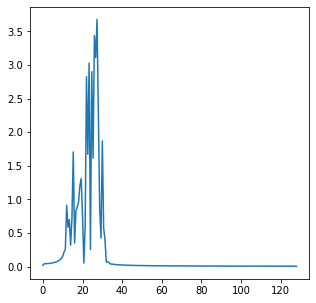

In [145]:
############################################ Averaged FFT over all trials and channels ############################################
f, fffft = fft_calculator(Train_Data_filtered[10,:,1], Fs)


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(f, fffft)

In [146]:
############################################ Apply the Feature Functions on Training Data ############################################

In [147]:
# get trial numbers of two classes
class1_trialnum = np.squeeze(np.asarray(np.where(np.squeeze(Train_Label) == 0)))
class2_trialnum = np.squeeze(np.asarray(np.where(np.squeeze(Train_Label) == 1)))

print(class1_trialnum.shape, class2_trialnum.shape)

(60,) (60,)


In [148]:
# merged features
merged = []

In [149]:
# calculate variance of each trail and channel - one value for each channel and trial for train data
var_feature = Var_Feature(selected_Data)


n_class = 2
var_feature_classes = np.zeros((n_class,int(var_feature.shape[1]/n_class),var_feature.shape[0]))

var_feature_classes[0,:,:] = var_feature.T[class1_trialnum,:]
var_feature_classes[1,:,:] = var_feature.T[class2_trialnum,:]
merged.append(var_feature_classes)

print(var_feature_classes.shape)

(2, 60, 30)


In [150]:
# calculate amplitude histogram - nbin values for each channel for training data
n_bins = 5
min_amp = -10
max_amp = 10
hist_feature = amp_hist_Feature(selected_Data, n_bins, min_amp, max_amp)

n_class = 2
hist_feature_classes = np.zeros((n_class,hist_feature.shape[0],int(hist_feature.shape[1]/n_class),hist_feature.shape[-1]))

hist_feature_classes[0,:,:,:] = hist_feature[:,class1_trialnum,:]
hist_feature_classes[1,:,:,:] = hist_feature[:,class2_trialnum,:]

for i in range (hist_feature.shape[-1]):
  merged.append(np.moveaxis(hist_feature_classes[:,:,:,i], 1, 2))

print(hist_feature_classes.shape)

(2, 30, 60, 5)


In [151]:
# calculate AR coefficients - order values for each trail and channel
order = 5
ar_feature = AR_Coeffs(selected_Data, order)

n_class = 2
ar_feature_classes = np.zeros((n_class,int(ar_feature.shape[0]/n_class),ar_feature.shape[1],ar_feature.shape[-1]))

ar_feature_classes[0,:,:,:] = ar_feature[class1_trialnum,:,:]
ar_feature_classes[1,:,:,:] = ar_feature[class2_trialnum,:,:]

for i in range (ar_feature.shape[-1]):
  merged.append(ar_feature_classes[:,:,:,i])

print(ar_feature_classes.shape)

(2, 60, 30, 6)


In [152]:
# calculate Form Factor -  one value for each channel and trial for training data
FF_feature = FF_Feature(selected_Data)

n_class = 2
FF_feature_classes = np.zeros((n_class,int(FF_feature.shape[1]/n_class),FF_feature.shape[0]))

FF_feature_classes[0,:,:] = FF_feature.T[class1_trialnum,:]
FF_feature_classes[1,:,:] = FF_feature.T[class2_trialnum,:]
merged.append(FF_feature_classes)

print(FF_feature_classes.shape)

(2, 60, 30)


In [153]:
# calculate cov_Feature -  one covariance matrix for each trial for training data
cov_feature = cov_Feature(selected_Data)

n_class = 2
cov_feature_classes = np.zeros((n_class,int(cov_feature.shape[0]/n_class),cov_feature.shape[1],cov_feature.shape[1]))

cov_feature_classes[0,:,:] = cov_feature[class1_trialnum,:]
cov_feature_classes[1,:,:] = cov_feature[class2_trialnum,:]

for i in range (cov_feature.shape[1]):
  merged.append(cov_feature_classes[:,:,:,i])


print(cov_feature_classes.shape)

(2, 60, 30, 30)


In [154]:
# calculate kurtosis_Feature -  one number for each trial and channel
kurt_feature = kurtosis_Feature(selected_Data)


n_class = 2
kurt_feature_classes = np.zeros((n_class,int(kurt_feature.shape[0]/n_class),kurt_feature.shape[1]))

kurt_feature_classes[0,:,:] = kurt_feature[class1_trialnum,:]
kurt_feature_classes[1,:,:] = kurt_feature[class2_trialnum,:]
merged.append(kurt_feature_classes)

print(kurt_feature_classes.shape)

(2, 60, 30)


In [157]:
# calculate lyapunov exponent - one number for each trial and channel
lyapunov_feature = lyapunov_Feature(selected_Data)

n_class = 2
lyapunov_feature_classes = np.zeros((n_class,int(lyapunov_feature.shape[0]/n_class),lyapunov_feature.shape[1]))

lyapunov_feature_classes[0,:,:] = lyapunov_feature[class1_trialnum,:]
lyapunov_feature_classes[1,:,:] = lyapunov_feature[class2_trialnum,:]
merged.append(lyapunov_feature_classes)

print(lyapunov_feature_classes.shape)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)

(2, 60, 30)


/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 96
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/nolds/measu

In [158]:
# calculate entropy - one number for each trial and channel
entropy_feature = entropy_Feature(selected_Data)

n_class = 2
entropy_feature_classes = np.zeros((n_class,int(entropy_feature.shape[0]/n_class),entropy_feature.shape[1]))

entropy_feature_classes[0,:,:] = entropy_feature[class1_trialnum,:]
entropy_feature_classes[1,:,:] = entropy_feature[class2_trialnum,:]
merged.append(entropy_feature_classes)

print(entropy_feature_classes.shape)

(2, 60, 30)


In [159]:
# calculate max_freq_Feature -  one max freq for each trail and channel for training data
f, max_freq_feature = max_freq_Feature(selected_Data, Fs)


n_class = 2
max_freq_feature_classes = np.zeros((n_class,int(max_freq_feature.shape[0]/n_class),max_freq_feature.shape[1]))

max_freq_feature_classes[0,:,:] = max_freq_feature[class1_trialnum,:]
max_freq_feature_classes[1,:,:] = max_freq_feature[class2_trialnum,:]
merged.append(max_freq_feature_classes)


print(max_freq_feature_classes.shape)

(2, 60, 30)


In [160]:
# calculate mean_freq_Feature -  one mean freq for each trail and channel for training data
f, mean_freq_feature = mean_freq_Feature(selected_Data, Fs)

n_class = 2
mean_freq_feature_classes = np.zeros((n_class,int(max_freq_feature.shape[0]/n_class),max_freq_feature.shape[1]))

mean_freq_feature_classes[0,:,:] = mean_freq_feature[class1_trialnum,:]
mean_freq_feature_classes[1,:,:] = mean_freq_feature[class2_trialnum,:]
merged.append(mean_freq_feature_classes)


print(mean_freq_feature_classes.shape)

(2, 60, 30)


In [161]:
# selected band energy - one energy for each trail and channel for training data
band_energy_feature = band_energy_Feature1(selected_Data, Fs)

n_class = 2
band_energy_feature_classes = np.zeros((n_class,int(band_energy_feature.shape[0]/n_class),band_energy_feature.shape[1],band_energy_feature.shape[-1]))
band_energy_feature_classes[0,:,:,:] = band_energy_feature[class1_trialnum,:,:]
band_energy_feature_classes[1,:,:,:] = band_energy_feature[class2_trialnum,:,:]

for i in range (band_energy_feature.shape[-1]):
  merged.append(band_energy_feature_classes[:,:,:,i])


print(band_energy_feature_classes.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead


(2, 60, 30, 5)


In [162]:
def fisher_score_cal(bothclass_data,class1_data,class2_data):
  # calculate fisher score for each channel
  mean_bothclass = np.mean(bothclass_data)
  mean_class1 = np.mean(class1_data)
  mean_class2 = np.mean(class2_data)

  var_class1 = np.var(class1_data)
  var_class2 = np.var(class2_data)

  score = ((mean_bothclass-mean_class1)**2 + (mean_bothclass-mean_class2)**2)/(var_class1+var_class2)

  return score

In [163]:
print(len(merged))

53


In [165]:
n_all_features = len(merged)
n_channel = 30
fisher_score = []
high_Fscored_features = []

thresh = 0.09

for i in range(n_all_features):
  for j in range(n_channel):
    selected_channel =  j
    selected_feature = merged[i][:,:,j]
    fisher_score.append(fisher_score_cal(selected_feature, selected_feature[0], selected_feature[1]))
    if(fisher_score[-1] > thresh):
      high_Fscored_features.append(np.asarray([i, j]))
  

print(len(fisher_score), len(high_Fscored_features))

findeds = np.where(np.asarray(fisher_score) > thresh)
print(findeds)

1590 20
(array([  69,   99,  107,  129,  137,  365,  422,  426,  430,  434,  451,
        571,  691,  702,  760,  764,  811,  822, 1529, 1569]),)


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [166]:
print(high_Fscored_features)

[array([2, 9]), array([3, 9]), array([ 3, 17]), array([4, 9]), array([ 4, 17]), array([12,  5]), array([14,  2]), array([14,  6]), array([14, 10]), array([14, 14]), array([15,  1]), array([19,  1]), array([23,  1]), array([23, 12]), array([25, 10]), array([25, 14]), array([27,  1]), array([27, 12]), array([50, 29]), array([52,  9])]


In [167]:
n_class = 2
n_class_trial = 60

all_training_features = np.zeros((n_class, n_class_trial, len(high_Fscored_features)))

for i in range(len(high_Fscored_features)):
  all_training_features[:,:,i] = merged[high_Fscored_features[i][0]][:,:,high_Fscored_features[i][1]]

print(all_training_features.shape)

(2, 60, 20)


In [168]:
# it seems that non of the features give us high fisher score just by them self

In [173]:
# for training data
# lets check some features together # 
group_features_class1 = all_training_features[0,:,:]
group_features_class2 = all_training_features[1,:,:]
group_features_both = np.concatenate((group_features_class1, group_features_class2), axis=0)


# normalize feature matrices 
group_features_both = stats.zscore(group_features_both, axis=0)
group_features_class1 = group_features_both[0:60,:]
group_features_class2 = group_features_both[60:120,:]

print(group_features_class1.shape, group_features_class2.shape, group_features_both.shape)

(60, 20) (60, 20) (120, 20)


In [174]:
# score

scores = []

n_rep = 1000
n_selected_features = 15
all_selected_features = []

for j in range (n_rep):
  selected_features = random.sample(range(group_features_both.shape[-1]), n_selected_features)
  all_selected_features.append(selected_features)

  group_1 = group_features_class1[:,selected_features]
  group_2 = group_features_class2[:,selected_features]
  both_groups = group_features_both[:,selected_features]

  S1 = np.zeros((group_1.shape[1],group_1.shape[1]))
  S2 = np.zeros((group_2.shape[1],group_2.shape[1]))

  n_trials = 60
  n_class = 2
  for i in range(n_trials):
    S1 += (group_1[i,:] - np.mean(group_1, axis=0)) @ (group_1[i,:] - np.mean(group_1, axis=0)).T
    S2 += (group_2[i,:] - np.mean(group_2, axis=0)) @ (group_2[i,:] - np.mean(group_2, axis=0)).T

  S1 /= n_trials
  S2 /= n_trials  

  Sw = S1+S2

  # between class matrix
  Sb = np.zeros((group_1.shape[1],group_1.shape[1]))

  mean_all = np.expand_dims(np.mean(both_groups, axis=0), axis=1)
  mean_class1 = np.expand_dims(np.mean(group_1, axis=0), axis=1)
  mean_class2 = np.expand_dims(np.mean(group_2, axis=0), axis=1)

  Sb = ((mean_class1-mean_all) @ (mean_class1-mean_all).T) + ((mean_class2-mean_all) @ (mean_class2-mean_all).T)


  # final score
  J = np.trace(Sb)/np.trace(Sw)
  print('final score is: ', J)
  scores.append(J)

print(np.max(scores))

target_feature = all_selected_features[np.argmax(scores)]


final score is:  0.007972863443976528
final score is:  0.007871809964137057
final score is:  0.007825099382942177
final score is:  0.007954219621280833
final score is:  0.00801733982980024
final score is:  0.008072344116203688
final score is:  0.007611364491994803
final score is:  0.007823497487321576
final score is:  0.007534619689549848
final score is:  0.007817875322016289
final score is:  0.007944889174007572
final score is:  0.007999387175116172
final score is:  0.007610310609249417
final score is:  0.008067529636356876
final score is:  0.007840680838737074
final score is:  0.0076404238391040505
final score is:  0.007919049800904132
final score is:  0.007487332089896315
final score is:  0.00771498781603194
final score is:  0.007780276567686369
final score is:  0.007799015385031425
final score is:  0.007827548967223544
final score is:  0.008112811386614275
final score is:  0.007862223287126217
final score is:  0.008010301238095338
final score is:  0.007750492167723662
final score i

In [171]:
# change y to one hot labels
# we have 2 classes, so our MLP will have 2 output neurons which one neuron 
# will be one and the others zero
from tensorflow.keras.utils import to_categorical

y_tr_hot = to_categorical(Train_Label)

print(y_tr_hot.shape)

(120, 2)


In [172]:
# Define the K-fold Cross Validator
# Setting up the layers
from tensorflow.keras.layers import Input, Dense, Activation, Softmax
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

final_features = group_features_both[:,target_feature]


fold_no = 1
acc_per_fold = []
loss_per_fold = []
input_layer_size = group_features_both[:,target_feature].shape[1]
for train, test in kfold.split(final_features, y_tr_hot):
  # CREATE MLP MODEL
  # Setting up the layers


  model = keras.Sequential([
                        Input(shape = (input_layer_size,)), # input layer
                        Dense(units = 10), # hidden layer one
                        Activation(activation = tf.math.tanh),
                        Dense(units = 10), # hidden layer two
                        Activation(activation = tf.math.tanh),
                        Dense(units = 2), # output layer
                        Softmax(axis = 1)
  ])

  # Compling the model

  # make our model ready for training
  # 1. optimizer 2. loss function 3. metrics

  model.compile(
      optimizer = keras.optimizers.SGD(learning_rate=0.001),
      loss = keras.losses.CategoricalCrossentropy(),
      metrics = ['accuracy']
  )

  print(f'Training for fold {fold_no} ...')


  hist = model.fit(
      final_features[train],
      y_tr_hot[train],
      batch_size=5,
  )

  # Generate generalization metrics
  scores = model.evaluate(final_features[test], y_tr_hot[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

Training for fold 1 ...
20/20 [==============================] - 0s 2ms/step - loss: 0.6990 - accuracy: 0.5417
Score for fold 1: loss of 0.63556307554245; accuracy of 58.33333134651184%
Training for fold 2 ...
20/20 [==============================] - 0s 2ms/step - loss: 0.7270 - accuracy: 0.5104
Score for fold 2: loss of 0.7522873878479004; accuracy of 45.83333432674408%
Training for fold 3 ...
20/20 [==============================] - 0s 2ms/step - loss: 0.7193 - accuracy: 0.5625
Score for fold 3: loss of 0.7485336661338806; accuracy of 41.66666567325592%
Training for fold 4 ...
20/20 [==============================] - 0s 2ms/step - loss: 0.7314 - accuracy: 0.5208
Score for fold 4: loss of 0.8402624726295471; accuracy of 41.66666567325592%
Training for fold 5 ...
20/20 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 0.5521
Score for fold 5: loss of 1.2387429475784302; accuracy of 45.83333432674408%
